In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import os

# List everything in your MyDrive
os.listdir('/content/drive/MyDrive')


['sanidhya photo.jpg',
 'Classroom',
 'Untitled spreadsheet.gsheet',
 'DocScanner 9 Jun 2022 11-01 (1).pdf',
 'WhatsApp Image 2022-12-11 at 5.45.23 PM.jpeg',
 'WhatsApp Image 2022-12-11 at 6.05.46 PM.jpeg',
 'Colab Notebooks',
 'Document from Sanidhya Patel.pdf',
 'Sanidhya aadhar card.pdf',
 'WhatsApp Image 2023-07-19 at 1.52.34 PM.pdf',
 'My Resume',
 '20118085_Sanidhyapatel.aac',
 'WhatsApp Image 2023-11-07 at 11.25.51 AM (1).pdf',
 '20118085_Sanidhya_Sales dashboard.pdf',
 'Sanidhya_Aadhar_Front.jpg',
 'HIMYM',
 'Certificate',
 "Sanidhya's_Resume (2).pdf.pdf",
 "Sanidhya's_Resume (1).pdf.pdf",
 'Sanidhya_PAN.pdf.pdf',
 'Screenshot 2024-06-10 135421.png',
 'Sanidhya_Patel_Resume_2024 (14).pdf',
 'Sanidhya_Patel_Resume_2024 (13).pdf',
 'Sanidhya_Patel_Resume_2024 (12).pdf',
 'Sanidhya_Patel_Resume_2024 (11).pdf',
 '20118085_Sanidhya_Resume.pdf.pdf',
 'Sanidhya_Patel_Resume_2024 (10).pdf',
 'Sanidhya_Patel_Resume_2024 (9).pdf',
 'Sanidhya_Patel_Resume_2024 (8).pdf',
 'Sanidhya_Patel_R

In [20]:
os.listdir('/content/drive/MyDrive/Blood_Group_Dataset')


['B-', 'A-', 'A+', 'AB+', 'O+', 'AB-', 'B+', 'O-']

In [21]:
import tensorflow as tf

BATCH_SIZE = 32
IMG_SIZE = (64, 64)

dataset_path = '/content/drive/MyDrive/Blood_Group_Dataset'

dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("Classes:", dataset.class_names)

Found 6000 files belonging to 8 classes.
Classes: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']


In [22]:
import os
from collections import Counter

dataset_path = "/content/drive/MyDrive/Blood_Group_Dataset"
class_names = os.listdir(dataset_path)  # folders per class
class_counts = {}

for class_name in class_names:
    class_folder = os.path.join(dataset_path, class_name)
    count = len(os.listdir(class_folder))
    class_counts[class_name] = count

print("Class Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")


Class Distribution:
B-: 741
A-: 1009
A+: 565
AB+: 708
O+: 852
AB-: 761
B+: 652
O-: 712


Here performing oversampling of the data as the classes were not balanced, we can perform either undersampling or oversampling but as we have only 6000 dataset so cutting down the dataset would not be a wise decision.

In [23]:
def oversample_class(class_name, count, max_count):
    # Convert class name to index if needed
    class_idx = class_to_idx[class_name]

    # Ensure dataset is unbatched
    unbatched_dataset = dataset.unbatch()

    # Filter dataset for the specific class
    class_dataset = unbatched_dataset.filter(
        lambda img, lbl: tf.equal(lbl, class_idx)
    )

    # Calculate repetitions needed
    repeat_factor = max_count // count + (1 if max_count % count > 0 else 0)

    # Repeat and take required number
    return class_dataset.repeat(repeat_factor).take(max_count)

Found 8072 files belonging to 8 classes.


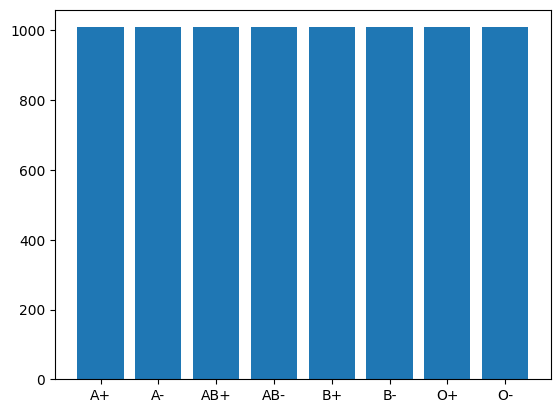

In [24]:
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# 1. Create dataset with proper labels
dataset_path = "/content/drive/MyDrive/Blood_Group_Balanced"
class_names = sorted(os.listdir(dataset_path))
class_to_idx = {name: i for i, name in enumerate(class_names)}

dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(64, 64),
    batch_size=32,
    label_mode='int',
    class_names=class_names
)

# 2. Get class counts
class_counts = Counter(int(lbl.numpy()) for _, lbl in dataset.unbatch())

# 3. Oversampling function (updated)
def oversample_class(class_idx, count, max_count):
    unbatched_dataset = dataset.unbatch()
    class_dataset = unbatched_dataset.filter(
        lambda img, lbl: tf.equal(lbl, class_idx)
    )
    repeat_factor = max_count // count + (1 if max_count % count > 0 else 0)
    return class_dataset.repeat(repeat_factor).take(max_count)

# 4. Balance the dataset
max_count = max(class_counts.values())
balanced_datasets = []
for class_idx, count in class_counts.items():
    balanced_datasets.append(oversample_class(class_idx, count, max_count))

# 5. Combine datasets
balanced_dataset = tf.data.Dataset.sample_from_datasets(
    balanced_datasets,
    weights=[1./len(balanced_datasets)]*len(balanced_datasets),
    seed=42
)

# 6. Verify balancing
balanced_counts = Counter(int(lbl.numpy()) for _, lbl in balanced_dataset)
plt.bar(class_names, [balanced_counts[i] for i in range(len(class_names))])
plt.show()

# 7. Batch for training
BATCH_SIZE = 32
balanced_dataset = balanced_dataset.batch(BATCH_SIZE)

Here as we can see now we have performed oversampling as well as balanced the data set upto 8072 and 1009 each

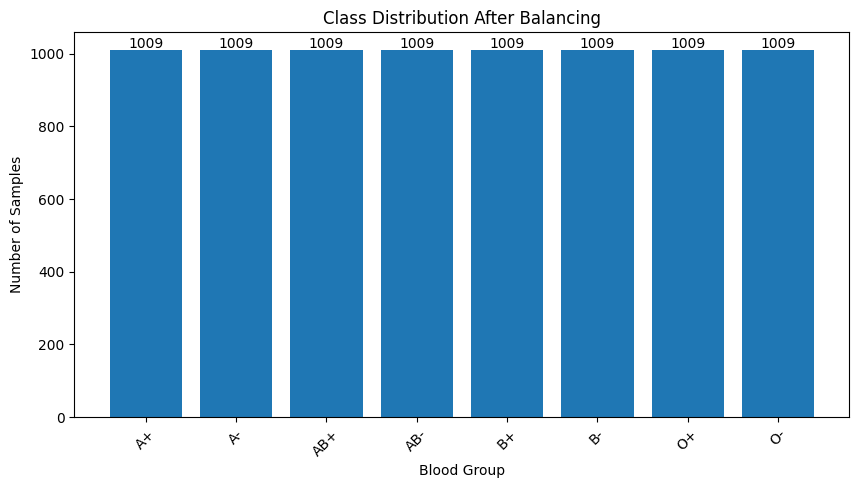

In [25]:
import matplotlib.pyplot as plt

# Get counts
class_counts = Counter(int(label.numpy()) for _, label in balanced_dataset.unbatch())

# Plot
plt.figure(figsize=(10, 5))
plt.bar(class_names, [class_counts[i] for i in range(len(class_names))])
plt.title("Class Distribution After Balancing")
plt.xlabel("Blood Group")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
for i, count in enumerate([class_counts[i] for i in range(len(class_names))]):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

Here we divide the dataset into Training testing and validation dataset in the follwoing ratio Training 70% or 0.7  Testing 15% or 0.15 Validation 15% or 0.15 and then we projected the dataset belongs to each class

In [26]:
# Constants
BATCH_SIZE = 32
train_ratio = 0.7  # 70% training
val_ratio = 0.15    # 15% validation
test_ratio = 0.15   # 15% test

# 1. Unbatch the dataset
balanced_dataset_unbatched = balanced_dataset.unbatch()

# 2. Compute dataset sizes
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size  # Accounts for rounding

# 3. Split the dataset
train_dataset = balanced_dataset_unbatched.take(train_size)
val_test_dataset = balanced_dataset_unbatched.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# 4. Rebatch the datasets
train_batches = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_batches = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_batches = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

# 5. Verify the splits
def count_batches(dataset):
    return sum(1 for _ in dataset)

print(f"Training dataset: {count_batches(train_batches)} batches ({count_batches(train_batches)*BATCH_SIZE} samples)")
print(f"Validation dataset: {count_batches(val_batches)} batches ({count_batches(val_batches)*BATCH_SIZE} samples)")
print(f"Testing dataset: {count_batches(test_batches)} batches ({count_batches(test_batches)*BATCH_SIZE} samples)")

# 6. Optional: Verify class distribution in each split
def check_class_distribution(dataset, name):
    class_dist = {i:0 for i in range(len(class_names))}
    for _, labels in dataset.unbatch():
        class_dist[labels.numpy()] += 1
    print(f"\n{class_names} distribution in {name}:")
    for cls, count in class_dist.items():
        print(f"{class_names[cls]}: {count} samples")

check_class_distribution(train_batches, "Training set")
check_class_distribution(val_batches, "Validation set")
check_class_distribution(test_batches, "Testing set")

Training dataset: 176 batches (5632 samples)
Validation dataset: 37 batches (1184 samples)
Testing dataset: 37 batches (1184 samples)

['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-'] distribution in Training set:
A+: 656 samples
A-: 733 samples
AB+: 737 samples
AB-: 697 samples
B+: 702 samples
B-: 665 samples
O+: 737 samples
O-: 705 samples

['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-'] distribution in Validation set:
A+: 127 samples
A-: 158 samples
AB+: 144 samples
AB-: 144 samples
B+: 146 samples
B-: 148 samples
O+: 162 samples
O-: 155 samples

['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-'] distribution in Testing set:
A+: 190 samples
A-: 110 samples
AB+: 124 samples
AB-: 167 samples
B+: 156 samples
B-: 189 samples
O+: 106 samples
O-: 142 samples


For Classification model i have used CNN and the number of layers i have used is 5 hiden layer and also the number of neurons i have used here is twice of the previous layer as you can see in the following code i.e 32 in First layer 64 in the second layer 128 in the third layer and so on and addition to that i have also used Dropout in each of the following layer as given below, it prevents the model to Overtrain also known as overfitting.

In [27]:
def create_high_accuracy_model():
    model = tf.keras.models.Sequential([
        # First Conv Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),

        # Second Conv Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        # Third Conv Block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        # Fourth Conv Block
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),

        # Fifth Conv Block
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.5),

        # Flatten and Dense Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        # Output Layer
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    return model

# Create the model
high_acc_model = create_high_accuracy_model()
high_acc_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         8,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,674,952 (14.02 MB)

 Trainable params: 3,674,952 (14.02 MB)

 Non-trainable params: 0 (0.00 B)

Here i have used two call back function ReduceLROnPleateau, to avoid hitting the plateau once it hit the plateau it will reduce the learning-rate by 0.5  and the second callback is EarlyStopping once there is no improving in accurracy it will will stop so it doesn't unncessary resource(CPU , GPU) utlization.

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

Epoch 1/22
    176/Unknown 226s 1s/step - accuracy: 0.1264 - loss: 30.4811

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


176/176 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - accuracy: 0.1264 - loss: 30.3561 - val_accuracy: 0.1201 - val_loss: 2.0203 - learning_rate: 0.0010
Epoch 2/22
176/176 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.2054 - loss: 1.9872 - val_accuracy: 0.2089 - val_loss: 1.9807 - learning_rate: 0.0010
Epoch 3/22
176/176 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.3054 - loss: 1.7797 - val_accuracy: 0.2648 - val_loss: 1.8862 - learning_rate: 0.0010
Epoch 4/22
176/176 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - accuracy: 0.3853 - loss: 1.5933 - val_accuracy: 0.4688 - val_loss: 1.5282 - learning_rate: 0.0010
Epoch 5/22
176/176 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.5513 - loss: 1.2036 - val_accuracy: 0.5263 - val_loss: 1.3222 - learning_rate: 0.0010
Epoch 6/22
176/176 ━━━━━━━━━━━━━━━━━━━━ 483s 2s/step - accuracy: 0.6337 - loss: 0.9875 - val_accuracy: 0.4720 - val_loss: 1.3401 - learning_rate: 0.0010
Epoch 7/22
176/176 ━━━━━━━━━━━━━━━━━━━━ 451s 3s/step - accuracy: 0.6793 - loss: 0.8790 - val

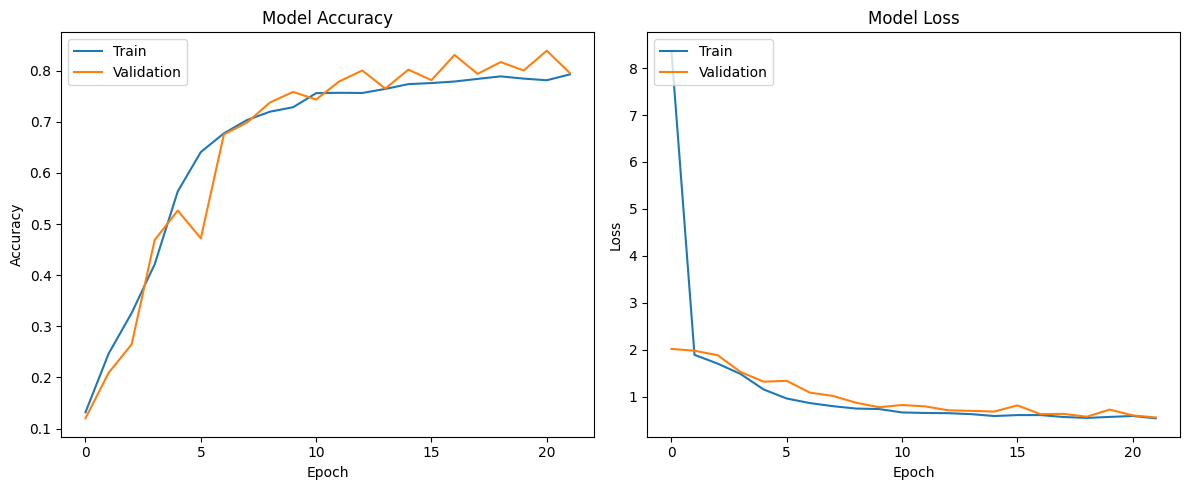

In [29]:
# Define callbacks first
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # Reduce learning rate by half
    patience=3,       # Wait for 3 epochs without improvement
    verbose=1,        # Print messages when reducing LR
    min_lr=1e-6       # Minimum learning rate
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,        # Stop after 5 epochs without improvement
    verbose=1,         # Print messages when stopping
    restore_best_weights=True  # Keep the best model weights
)

# Train the model
history_high_acc = high_acc_model.fit(
    train_batches,          # Make sure this is your batched training data
    validation_data=val_batches,  # Batched validation data
    epochs=22,
    callbacks=[reduce_lr, early_stop],
    verbose=1               # Show progress bars
)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_high_acc.history['accuracy'])
plt.plot(history_high_acc.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_high_acc.history['loss'])
plt.plot(history_high_acc.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model in HDF5 (.h5) format
high_acc_model.save('high_accuracy_model.h5')


In [ ]:
# Save the trained model in HDF5 (.h5) format
high_acc_model.save('high_accuracy_model.h5')


Here we calculated all the matrices such as AUC, Accuracy, BPCER, APCER, TDR, F1-Score, Precision, Recall and also Confusion matrix.

37/37 ━━━━━━━━━━━━━━━━━━━━ 201s 980ms/step - accuracy: 0.8232 - loss: 0.5595


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Basic Evaluation:
Validation Loss: 0.5508
Validation Accuracy: 0.8010
37/37 ━━━━━━━━━━━━━━━━━━━━ 216s 962ms/step

COMPREHENSIVE PERFORMANCE METRICS:
Class     AUC     F1      Prec    Rec     BPCER   APCER   TDR     
----------------------------------------------------------------------
A+        0.9967  0.8843  0.9304  0.8425  0.0189  0.0630  0.8425
A-        0.9758  0.7843  0.7035  0.8861  0.0175  0.3734  0.8861
AB+       0.9933  0.8270  0.7157  0.9792  0.0029  0.3889  0.9792
AB-       0.9870  0.8048  0.9439  0.7014  0.0413  0.0417  0.7014
B+        0.9931  0.9158  0.9007  0.9315  0.0096  0.1027  0.9315
B-        0.9941  0.8767  0.8889  0.8649  0.0193  0.1081  0.8649
O+        0.9781  0.7483  0.8629  0.6605  0.0538  0.1049  0.6605
O-        0.9809  0.7947  0.8163  0.7742  0.0340  0.1742  0.7742

MACRO AVERAGES:
AUC: 0.9874 | F1: 0.8295 | Precision: 0.8453 | Recall: 0.8300
BPCER: 0.0247 | APCER: 0.1696 | TDR: 0.8300


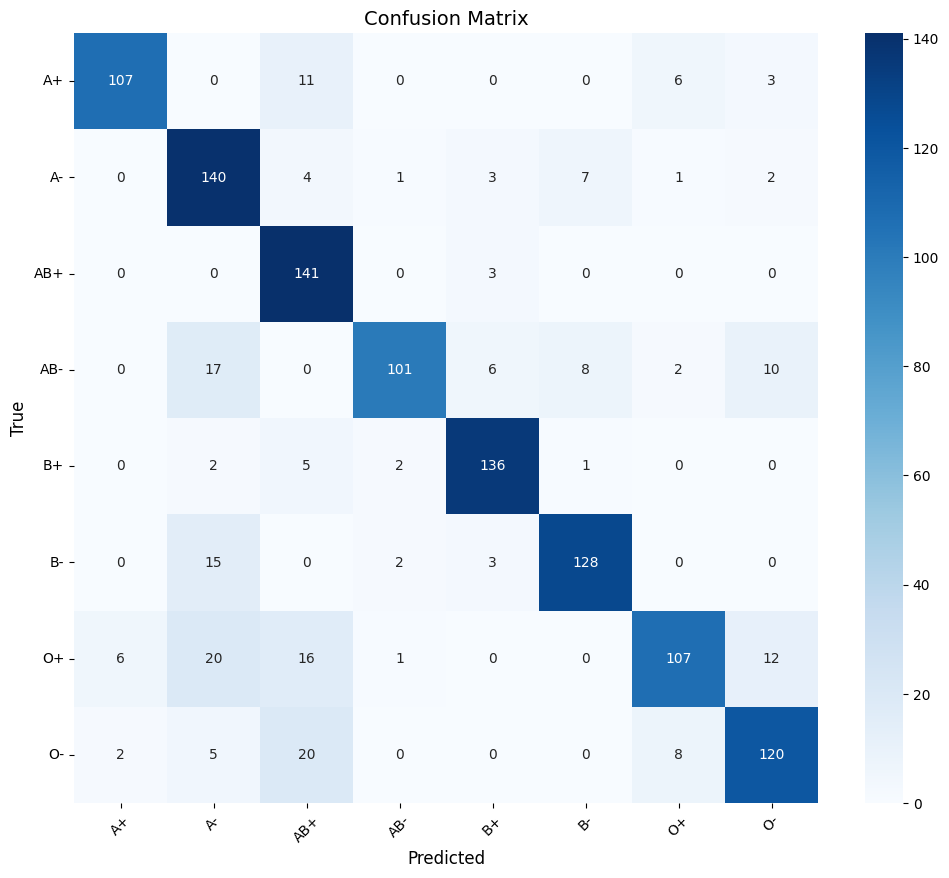

In [30]:
import numpy as np
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score,
                           precision_score, recall_score, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Basic Evaluation
val_loss, val_acc = high_acc_model.evaluate(val_batches)
print(f"\nBasic Evaluation:")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# 2. Get predictions and true labels
val_preds = high_acc_model.predict(val_batches)
val_pred_classes = np.argmax(val_preds, axis=1)
val_true_labels = np.concatenate([y for x, y in val_batches], axis=0)

# 3. Calculate all metrics
n_classes = len(class_names)
metrics = {
    'AUC': [],
    'F1-Score': [],
    'Precision': [],
    'Recall': [],
    'BPCER': [],
    'APCER': [],
    'TDR': []
}

# Calculate confusion matrix
cm = confusion_matrix(val_true_labels, val_pred_classes)

# One-vs-Rest calculation for each class
for i in range(n_classes):
    # AUC
    auc = roc_auc_score((val_true_labels == i).astype(int), val_preds[:, i])
    metrics['AUC'].append(auc)

    # Standard metrics
    metrics['F1-Score'].append(f1_score(val_true_labels == i, val_pred_classes == i, zero_division=0))
    metrics['Precision'].append(precision_score(val_true_labels == i, val_pred_classes == i, zero_division=0))
    metrics['Recall'].append(recall_score(val_true_labels == i, val_pred_classes == i, zero_division=0))

    # Security metrics
    TP = cm[i,i]
    FP = cm[:,i].sum() - TP
    FN = cm[i,:].sum() - TP
    TN = cm.sum() - TP - FP - FN

    metrics['BPCER'].append(FN / (TN + FP + 1e-10))  # False Negative Rate
    metrics['APCER'].append(FP / (TP + FN + 1e-10))  # False Positive Rate
    metrics['TDR'].append(TP / (TP + FN + 1e-10))    # True Detection Rate (Recall)

# 4. Print comprehensive report
print("\nCOMPREHENSIVE PERFORMANCE METRICS:")
print("="*50)
print(f"{'Class':<10}{'AUC':<8}{'F1':<8}{'Prec':<8}{'Rec':<8}{'BPCER':<8}{'APCER':<8}{'TDR':<8}")
print("-"*70)
for i, class_name in enumerate(class_names):
    print(f"{class_name:<10}{metrics['AUC'][i]:.4f}  {metrics['F1-Score'][i]:.4f}  "
          f"{metrics['Precision'][i]:.4f}  {metrics['Recall'][i]:.4f}  "
          f"{metrics['BPCER'][i]:.4f}  {metrics['APCER'][i]:.4f}  "
          f"{metrics['TDR'][i]:.4f}")

# Macro averages
print("\nMACRO AVERAGES:")
print(f"AUC: {np.mean(metrics['AUC']):.4f} | F1: {np.mean(metrics['F1-Score']):.4f} | "
      f"Precision: {np.mean(metrics['Precision']):.4f} | Recall: {np.mean(metrics['Recall']):.4f}")
print(f"BPCER: {np.mean(metrics['BPCER']):.4f} | APCER: {np.mean(metrics['APCER']):.4f} | "
      f"TDR: {np.mean(metrics['TDR']):.4f}")

# 5. Confusion matrix visualization
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Convert the model to ONNX format and compare its performance.



In [31]:
!pip install tf2onnx onnx onnxruntime

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<

In [33]:
import onnx


Here i have Convereted the model to ONNX

In [34]:
import tensorflow as tf
import tf2onnx

# Convert Sequential model to Functional API format
input_layer = tf.keras.layers.Input(shape=(64, 64, 3))
functional_model = tf.keras.models.Model(
    inputs=input_layer,
    outputs=high_acc_model(input_layer)
)

# Now convert to ONNX
onnx_model, _ = tf2onnx.convert.from_keras(
    functional_model,
    input_signature=[tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32)],
    opset=13
)

# Save the model
onnx.save(onnx_model, "blood_group_classifier.onnx")
print("✅ Conversion successful!")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7992e45019e0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


✅ Conversion successful!


In [35]:
import onnxruntime as ort

# Load the ONNX model
ort_session = ort.InferenceSession("blood_group_classifier.onnx")
print("ONNX model input:", ort_session.get_inputs()[0].name)
print("ONNX model output:", ort_session.get_outputs()[0].name)

ONNX model input: args_0
ONNX model output: sequential


In [36]:
import time
import numpy as np

# Test data (use your test_batches)
sample_images, _ = next(iter(test_batches))
sample_image = sample_images[0:1]  # Take one image

# TensorFlow Inference
start_time = time.time()
tf_output = high_acc_model.predict(sample_image)
tf_time = time.time() - start_time

# ONNX Inference
ort_session = ort.InferenceSession("blood_group_classifier.onnx")
input_name = ort_session.get_inputs()[0].name

start_time = time.time()
onnx_output = ort_session.run(None, {input_name: sample_image.numpy()})[0]
onnx_time = time.time() - start_time

print(f"TensorFlow Inference Time: {tf_time:.4f}s")
print(f"ONNX Inference Time: {onnx_time:.4f}s")
print(f"Speedup: {tf_time/onnx_time:.2f}x")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
TensorFlow Inference Time: 0.3360s
ONNX Inference Time: 0.0045s
Speedup: 75.18x


Here i have compared the parametes such as AUC, Recall, Accurracy, F1 Score, APCER, BPCER, TDR and Precision of the Tensor-flow model and ONNX and calculated the difference between them.

In [37]:
import numpy as np
from sklearn.metrics import (roc_auc_score, accuracy_score, f1_score,
                           precision_score, recall_score, confusion_matrix)
import pandas as pd

def calculate_metrics(model, dataset, is_onnx=False, input_name=None):
    """Calculate all metrics for either TensorFlow or ONNX model"""
    y_true = []
    y_pred = []
    y_scores = []

    for images, labels in dataset:
        y_true.extend(labels.numpy())

        if is_onnx:  # ONNX model
            ort_session = model
            outputs = ort_session.run(None, {input_name: images.numpy()})[0]
            y_scores.extend(outputs)
            y_pred.extend(np.argmax(outputs, axis=1))
        else:  # TensorFlow model
            outputs = model.predict(images, verbose=0)
            y_scores.extend(outputs)
            y_pred.extend(np.argmax(outputs, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)

    # One-vs-Rest calculation for multi-class
    n_classes = len(class_names)
    metrics = {
        'AUC': [],
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': [],
        'Precision': [],
        'Recall': [],
        'BPCER': [],
        'APCER': [],
        'TDR': []
    }

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    for i in range(n_classes):
        # AUC (One-vs-Rest)
        metrics['AUC'].append(roc_auc_score((y_true == i).astype(int), y_scores[:, i]))

        # Standard metrics
        metrics['F1-Score'].append(f1_score(y_true == i, y_pred == i, zero_division=0))
        metrics['Precision'].append(precision_score(y_true == i, y_pred == i, zero_division=0))
        metrics['Recall'].append(recall_score(y_true == i, y_pred == i, zero_division=0))

        # Security metrics
        TP = cm[i,i]
        FP = cm[:,i].sum() - TP
        FN = cm[i,:].sum() - TP
        TN = cm.sum() - TP - FP - FN

        metrics['BPCER'].append(FN / (TN + FP + 1e-10))  # False Negative Rate
        metrics['APCER'].append(FP / (TP + FN + 1e-10))   # False Positive Rate
        metrics['TDR'].append(TP / (TP + FN + 1e-10))     # True Detection Rate

    # Convert lists to averages
    for k in ['AUC', 'F1-Score', 'Precision', 'Recall', 'BPCER', 'APCER', 'TDR']:
        metrics[k] = np.mean(metrics[k])

    return metrics

# Calculate for both models
tf_metrics = calculate_metrics(high_acc_model, test_batches)
onnx_metrics = calculate_metrics(ort_session, test_batches, is_onnx=True,
                                input_name=ort_session.get_inputs()[0].name)

# Create comparison table
comparison = pd.DataFrame({
    'Metric': ['AUC', 'Accuracy', 'F1-Score', 'Precision', 'Recall',
               'BPCER', 'APCER', 'TDR'],
    'TensorFlow': [tf_metrics[k] for k in ['AUC', 'Accuracy', 'F1-Score',
                                         'Precision', 'Recall',
                                         'BPCER', 'APCER', 'TDR']],
    'ONNX': [onnx_metrics[k] for k in ['AUC', 'Accuracy', 'F1-Score',
                                      'Precision', 'Recall',
                                      'BPCER', 'APCER', 'TDR']]
})

# Calculate absolute differences
comparison['Difference'] = np.abs(comparison['TensorFlow'] - comparison['ONNX'])

print(comparison.round(4))

      Metric  TensorFlow    ONNX  Difference
0        AUC      0.9844  0.9844      0.0000
1   Accuracy      0.8049  0.8057      0.0008
2   F1-Score      0.7950  0.7950      0.0000
3  Precision      0.8101  0.8107      0.0006
4     Recall      0.8027  0.8019      0.0008
5      BPCER      0.0280  0.0279      0.0002
6      APCER      0.2230  0.2213      0.0017
7        TDR      0.8027  0.8019      0.0008


Convert the model to TensorFlow Lite (TFLite) format



In [38]:
import tensorflow as tf

# Convert to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(high_acc_model)
tflite_model = converter.convert()

# Save the model
with open("blood_group_classifier.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite conversion successful!")


Saved artifact at '/tmp/tmpg8ot_aqy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  133672071149712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133672071146064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133672071150864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133672071149520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133672073037392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133672073039120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133672073039504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133672073041040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133672073040848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133672073041616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133672073039696:

In [39]:
import numpy as np
import time

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="blood_group_classifier.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare a sample image
sample_images, _ = next(iter(test_batches))
sample_image = sample_images[0:1].numpy().astype(np.float32)

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], sample_image)

# Run inference
start_time = time.time()
interpreter.invoke()
tflite_output = interpreter.get_tensor(output_details[0]['index'])
tflite_time = time.time() - start_time

print(f"TFLite Inference Time: {tflite_time:.4f}s")


TFLite Inference Time: 0.0204s


In [40]:
# TensorFlow Inference
start_time = time.time()
tf_output = high_acc_model.predict(sample_image)
tf_time = time.time() - start_time

# ONNX Inference
import onnxruntime as ort
ort_session = ort.InferenceSession("blood_group_classifier.onnx")
input_name = ort_session.get_inputs()[0].name
start_time = time.time()
onnx_output = ort_session.run(None, {input_name: sample_image})[0]
onnx_time = time.time() - start_time

# Final comparison
print(f"TensorFlow Inference Time: {tf_time:.4f}s")
print(f"ONNX Inference Time: {onnx_time:.4f}s")
print(f"TFLite Inference Time: {tflite_time:.4f}s")
print(f"ONNX Speedup: {tf_time/onnx_time:.2f}x")
print(f"TFLite Speedup: {tf_time/tflite_time:.2f}x")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
TensorFlow Inference Time: 0.1312s
ONNX Inference Time: 0.0050s
TFLite Inference Time: 0.0204s
ONNX Speedup: 26.20x
TFLite Speedup: 6.43x


In [41]:
def calculate_metrics_tflite(interpreter, dataset):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    y_true = []
    y_pred = []
    y_scores = []

    for images, labels in dataset:
        y_true.extend(labels.numpy())
        for img in images:
            img = np.expand_dims(img.numpy().astype(np.float32), axis=0)
            interpreter.set_tensor(input_details[0]['index'], img)
            interpreter.invoke()
            pred = interpreter.get_tensor(output_details[0]['index'])[0]
            y_scores.append(pred)
            y_pred.append(np.argmax(pred))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_scores = np.array(y_scores)

    n_classes = len(class_names)
    metrics = {
        'AUC': [],
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': [],
        'Precision': [],
        'Recall': [],
        'BPCER': [],
        'APCER': [],
        'TDR': []
    }

    cm = confusion_matrix(y_true, y_pred)

    for i in range(n_classes):
        metrics['AUC'].append(roc_auc_score((y_true == i).astype(int), y_scores[:, i]))
        metrics['F1-Score'].append(f1_score(y_true == i, y_pred == i, zero_division=0))
        metrics['Precision'].append(precision_score(y_true == i, y_pred == i, zero_division=0))
        metrics['Recall'].append(recall_score(y_true == i, y_pred == i, zero_division=0))

        TP = cm[i,i]
        FP = cm[:,i].sum() - TP
        FN = cm[i,:].sum() - TP
        TN = cm.sum() - TP - FP - FN

        metrics['BPCER'].append(FN / (TN + FP + 1e-10))
        metrics['APCER'].append(FP / (TP + FN + 1e-10))
        metrics['TDR'].append(TP / (TP + FN + 1e-10))

    for k in ['AUC', 'F1-Score', 'Precision', 'Recall', 'BPCER', 'APCER', 'TDR']:
        metrics[k] = np.mean(metrics[k])

    return metrics


In [42]:
interpreter = tf.lite.Interpreter(model_path="blood_group_classifier.tflite")
interpreter.allocate_tensors()

tflite_metrics = calculate_metrics_tflite(interpreter, test_batches)


Comparisons between ONNX and TFlite based on parameters such as AUC,Accuracy,F1-Score, Precision, Recall, APCER, BPCER and TDR. here the Δ ONNX define as the absolute difference between (TensorFlow and ONNX) and Δ TFLite define as the absolute difference between(TensorFlow and Tflite)

In [43]:
comparison = pd.DataFrame({
    'Metric': ['AUC', 'Accuracy', 'F1-Score', 'Precision', 'Recall',
               'BPCER', 'APCER', 'TDR'],
    'TensorFlow': [tf_metrics[k] for k in ['AUC', 'Accuracy', 'F1-Score',
                                           'Precision', 'Recall',
                                           'BPCER', 'APCER', 'TDR']],
    'ONNX': [onnx_metrics[k] for k in ['AUC', 'Accuracy', 'F1-Score',
                                       'Precision', 'Recall',
                                       'BPCER', 'APCER', 'TDR']],
    'TFLite': [tflite_metrics[k] for k in ['AUC', 'Accuracy', 'F1-Score',
                                           'Precision', 'Recall',
                                           'BPCER', 'APCER', 'TDR']],
})

# Optional: Differences from TensorFlow
comparison['Δ ONNX'] = np.abs(comparison['TensorFlow'] - comparison['ONNX'])
comparison['Δ TFLite'] = np.abs(comparison['TensorFlow'] - comparison['TFLite'])

print(comparison.round(4))


      Metric  TensorFlow    ONNX  TFLite  Δ ONNX  Δ TFLite
0        AUC      0.9844  0.9844  0.9845  0.0000    0.0001
1   Accuracy      0.8049  0.8057  0.8108  0.0008    0.0059
2   F1-Score      0.7950  0.7950  0.8019  0.0000    0.0068
3  Precision      0.8101  0.8107  0.8153  0.0006    0.0052
4     Recall      0.8027  0.8019  0.8093  0.0008    0.0065
5      BPCER      0.0280  0.0279  0.0272  0.0002    0.0008
6      APCER      0.2230  0.2213  0.2158  0.0017    0.0072
7        TDR      0.8027  0.8019  0.8093  0.0008    0.0065


 Comparisons between all three (Tensorflow, ONNX, TFlite) based on certain parameters which are following
 AUC

Accuracy

BPCER

APCER

TDR

F1-Score

Precision

Recall

In [44]:
import pandas as pd
import numpy as np

# List of evaluation metrics
metric_names = ['AUC', 'Accuracy', 'F1-Score', 'Precision', 'Recall',
                'BPCER', 'APCER', 'TDR']

# Construct comparison DataFrame
comparison_df = pd.DataFrame({
    'Metric': metric_names,
    'TensorFlow': [tf_metrics[m] for m in metric_names],
    'ONNX': [onnx_metrics[m] for m in metric_names],
    'TFLite': [tflite_metrics[m] for m in metric_names],
})

# Optionally add differences from TensorFlow
comparison_df['Δ ONNX (abs)'] = np.abs(comparison_df['TensorFlow'] - comparison_df['ONNX'])
comparison_df['Δ TFLite (abs)'] = np.abs(comparison_df['TensorFlow'] - comparison_df['TFLite'])

# Round for cleaner presentation
print(comparison_df.round(4))


      Metric  TensorFlow    ONNX  TFLite  Δ ONNX (abs)  Δ TFLite (abs)
0        AUC      0.9844  0.9844  0.9845        0.0000          0.0001
1   Accuracy      0.8049  0.8057  0.8108        0.0008          0.0059
2   F1-Score      0.7950  0.7950  0.8019        0.0000          0.0068
3  Precision      0.8101  0.8107  0.8153        0.0006          0.0052
4     Recall      0.8027  0.8019  0.8093        0.0008          0.0065
5      BPCER      0.0280  0.0279  0.0272        0.0002          0.0008
6      APCER      0.2230  0.2213  0.2158        0.0017          0.0072
7        TDR      0.8027  0.8019  0.8093        0.0008          0.0065
